# Revenue Forecast

XGBoost will be chosen as the global predictor for its ensemble nature, ability to model interactions, CUDA compatibility, and model explainability.

## Hyperparameter Tuning

### Importing data

In [1]:
import xgboost as xgb
import pandas as pd
from xgboost import XGBRegressor
import joblib
from sklearn.preprocessing import StandardScaler
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pathlib, time
import optuna

In [ ]:
data = pd.read_csv("../data/curated/revenue_forecast_dataset.csv")

In [3]:
data['type'] = data['type'].astype('category')
data['month'] = data['month'].astype('category')
data['merchant_abn'] = data['merchant_abn'].astype('category')

In [4]:
data.head(5)

,merchant_abn,year_month,relative_time,month,monthly_revenue,abs_retail,abs_retail_lag1,abs_retail_lag2,cpi,cpi_lag1,cpi_lag2,rba_cash_rate,rba_cash_rate_lag1,rba_cash_rate_lag2,take_rate,type,monthly_revenue_future1
0,10023283211,2021-03,1,Mar,24634.345496,30336.0,26777.2,30108.5,105.6,105.3,105.4,0.03,0.03,0.03,0.18,e,27622.342754
1,10023283211,2021-04,2,Apr,27622.342754,29266.9,30336.0,26777.2,106.1,105.6,105.3,0.03,0.03,0.03,0.18,e,30111.883261
2,10023283211,2021-05,3,May,30111.883261,30216.8,29266.9,30336.0,106.2,106.1,105.6,0.03,0.03,0.03,0.18,e,28790.434289
3,10023283211,2021-06,4,Jun,28790.434289,29433.8,30216.8,29266.9,106.4,106.2,106.1,0.03,0.03,0.03,0.18,e,29430.731910
4,10023283211,2021-07,5,Jul,29430.731910,29172.7,29433.8,30216.8,106.7,106.4,106.2,0.03,0.03,0.03,0.18,e,32118.491547


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97284 entries, 0 to 97283
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   merchant_abn             97284 non-null  category
 1   year_month               97284 non-null  object  
 2   relative_time            97284 non-null  int64   
 3   month                    97284 non-null  category
 4   monthly_revenue          97284 non-null  float64 
 5   abs_retail               97284 non-null  float64 
 6   abs_retail_lag1          97284 non-null  float64 
 7   abs_retail_lag2          97284 non-null  float64 
 8   cpi                      97284 non-null  float64 
 9   cpi_lag1                 97284 non-null  float64 
 10  cpi_lag2                 97284 non-null  float64 
 11  rba_cash_rate            97284 non-null  float64 
 12  rba_cash_rate_lag1       97284 non-null  float64 
 13  rba_cash_rate_lag2       97284 non-null  float64 
 14  take_r

### Train and Validation Split

In [4]:
train = data[(data['year_month'] >= '2021-03') & (data['year_month'] <= '2022-02')]
x_train = train.drop(columns=['monthly_revenue_future1', 'year_month'])
y_train = train['monthly_revenue_future1']

val = data[(data['year_month'] >= '2022-03') & (data['year_month'] <= '2022-04')]
x_val = val.drop(columns=['monthly_revenue_future1', 'year_month'])
y_val = val['monthly_revenue_future1']

In [5]:
train["monthly_revenue"].mean(), train["monthly_revenue"].std()

(25667.476479880344, 60113.4027092327)

### Standardisation

In [6]:
# standardize only numerical features

# Check what columns we actually have in x_train
print(f"Available columns in x_train: {x_train.columns.tolist()}")

# Identify categorical and numerical columns from what's actually available
available_categorical_cols = ['type', 'month', 'merchant_abn']  # include merchant_abn as categorical
numerical_cols = [col for col in x_train.columns if col not in available_categorical_cols]

print(f"Categorical columns: {available_categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Scale only numerical features
scaler = StandardScaler()
x_train_numerical_scaled = scaler.fit_transform(x_train[numerical_cols])
x_val_numerical_scaled = scaler.transform(x_val[numerical_cols])

# Combine scaled numerical with categorical features
x_train_scaled = pd.DataFrame(x_train_numerical_scaled, columns=numerical_cols, index=x_train.index)
x_train_scaled = pd.concat([x_train_scaled, x_train[available_categorical_cols]], axis=1)

x_val_scaled = pd.DataFrame(x_val_numerical_scaled, columns=numerical_cols, index=x_val.index)
x_val_scaled = pd.concat([x_val_scaled, x_val[available_categorical_cols]], axis=1)

print(f"Final training shape: {x_train_scaled.shape}")
print(f"Final validation shape: {x_val_scaled.shape}")

Available columns in x_train: ['merchant_abn', 'relative_time', 'month', 'monthly_revenue', 'abs_retail', 'abs_retail_lag1', 'abs_retail_lag2', 'cpi', 'cpi_lag1', 'cpi_lag2', 'rba_cash_rate', 'rba_cash_rate_lag1', 'rba_cash_rate_lag2', 'take_rate', 'type']
Categorical columns: ['type', 'month', 'merchant_abn']
Numerical columns: ['relative_time', 'monthly_revenue', 'abs_retail', 'abs_retail_lag1', 'abs_retail_lag2', 'cpi', 'cpi_lag1', 'cpi_lag2', 'rba_cash_rate', 'rba_cash_rate_lag1', 'rba_cash_rate_lag2', 'take_rate']
Final training shape: (48312, 15)
Final validation shape: (8052, 15)


In [ ]:
# export the scaling parameters
joblib.dump(scaler, '../data/curated/revenue_forecast_scaler.pkl')

['data/curated/revenue_forecast_scaler.pkl']

### Optimal Hyperparameter Search Loop

In [8]:
sampler = optuna.samplers.TPESampler(seed=42, multivariate=True)
study = optuna.create_study(direction="minimize", sampler=sampler)

/opt/anaconda3/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-10-03 19:11:56,118] A new study created in memory with name: no-name-6ea4d36e-7617-48e9-8e34-e1e6e5e71778


In [12]:
def objective(trial: optuna.trial.Trial) -> float:
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "device": "cuda",
        "tree_method": "hist",
        "enable_categorical": True,
        "max_cat_to_onehot": 1,
        
        # High-impact knobs
        "max_depth": trial.suggest_int("max_depth", 4, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 20),
        "gamma": trial.suggest_float("gamma", 0.0, 1.5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 15.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 5.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.12),
        "max_bin": trial.suggest_categorical("max_bin", [256, 512]),
        "random_state": 42,

        # Early stopping
        "n_estimators": 10000,           # big ceiling; we'll stop early
        "early_stopping_rounds": 80,     # patience (constructor param in XGB 2.x/3.x)
    }

    model = XGBRegressor(**params)

    model.fit(
        x_train_scaled, y_train,
        eval_set=[(x_val_scaled, y_val)],   # drives early stopping
        verbose=False,
    )

    # Store the best number of estimators in the trial's user attributes
    trial.set_user_attr("best_n_estimators", model.best_iteration + 1)

    return float(model.best_score)          # Optuna minimizes this (val MAE at best iter)

In [13]:
N_TRIALS = 100

study.optimize(objective, n_trials=N_TRIALS, n_jobs=1, gc_after_trial=True)
print("Best val MAE :", study.best_value)
print("Best params  :", study.best_params)

[I 2025-09-28 23:49:26,098] Trial 0 finished with value: 5286.528669258956 and parameters: {'max_depth': 5, 'min_child_weight': 20, 'gamma': 1.0979909127171077, 'reg_lambda': 0.7968819297998435, 'reg_alpha': 0.003776663327107336, 'subsample': 0.7467983561008608, 'colsample_bytree': 0.7174250836504598, 'learning_rate': 0.10795585311974416, 'max_bin': 512}. Best is trial 0 with value: 5286.528669258956.
[I 2025-09-28 23:49:29,275] Trial 1 finished with value: 5087.466346802835 and parameters: {'max_depth': 4, 'min_child_weight': 20, 'gamma': 1.2486639612006325, 'reg_lambda': 0.047250715948919414, 'reg_alpha': 0.004705059281907645, 'subsample': 0.7550213529560301, 'colsample_bytree': 0.7912726728878613, 'learning_rate': 0.0772280788469014, 'max_bin': 256}. Best is trial 1 with value: 5087.466346802835.
[I 2025-09-28 23:49:29,275] Trial 1 finished with value: 5087.466346802835 and parameters: {'max_depth': 4, 'min_child_weight': 20, 'gamma': 1.2486639612006325, 'reg_lambda': 0.047250715948

Best val MAE : 4606.8589542154705
Best params  : {'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.3312207106640035, 'reg_lambda': 13.026102601575124, 'reg_alpha': 0.012211764741229649, 'subsample': 0.9922405872712441, 'colsample_bytree': 0.7275791676121519, 'learning_rate': 0.03402810811212028, 'max_bin': 256}


In [ ]:
path = pathlib.Path("../artifacts"); path.mkdir(exist_ok=True, parents=True)
save_path = path / "xgb_best_params.json"

# Get the best number of estimators from the best trial
best_n_estimators = study.best_trial.user_attrs.get("best_n_estimators", 1000)

best_params = {
    **study.best_params,
    # include fixed fields so it's self-contained
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "device": "cuda",
    "tree_method": "hist",
    "random_state": 42,
    "n_estimators": best_n_estimators,  # use the optimal number from early stopping
}

with open(save_path, "w") as f:
    json.dump({
        "params": best_params,
        "best_val_mae": float(study.best_value),
        "best_n_estimators": best_n_estimators,
        "saved_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    }, f, indent=2)

print("Saved →", save_path)
print(f"Best n_estimators: {best_n_estimators}")

Saved → artifacts/xgb_best_params.json
Best n_estimators: 311


## Testing

In [ ]:
data = pd.read_csv("../data/curated/revenue_forecast_dataset.csv")

# Convert to categorical (same as in training)
data['type'] = data['type'].astype('category')
data['month'] = data['month'].astype('category')
data['merchant_abn'] = data['merchant_abn'].astype('category')

scaler = joblib.load('../data/curated/revenue_forecast_scaler.pkl')

In [ ]:
# Load the best hyperparameters from the saved JSON file
with open('../artifacts/xgb_best_params.json', 'r') as f:
    saved_params = json.load(f)
    best_params = saved_params['params']

print("Loaded hyperparameters:")
print(json.dumps(best_params, indent=2))

Loaded hyperparameters:
{
  "max_depth": 4,
  "min_child_weight": 2,
  "gamma": 0.3312207106640035,
  "reg_lambda": 13.026102601575124,
  "reg_alpha": 0.012211764741229649,
  "subsample": 0.9922405872712441,
  "colsample_bytree": 0.7275791676121519,
  "learning_rate": 0.03402810811212028,
  "max_bin": 256,
  "objective": "reg:squarederror",
  "eval_metric": "mae",
  "device": "cuda",
  "tree_method": "hist",
  "random_state": 42,
  "n_estimators": 311
}


In [11]:
# Create training split (March 2021 to May 2022)
train_full = data[(data['year_month'] >= '2021-03') & (data['year_month'] <= '2022-05')]
x_train_full = train_full.drop(columns=['monthly_revenue_future1', 'year_month'])  # keep merchant_abn now
y_train_full = train_full['monthly_revenue_future1']

# Scale only numerical features (same as in hyperparameter tuning)
available_categorical_cols = ['type', 'month', 'merchant_abn']  # include merchant_abn as categorical
numerical_cols = [col for col in x_train_full.columns if col not in available_categorical_cols]

# Scale numerical features
x_train_full_numerical_scaled = scaler.transform(x_train_full[numerical_cols])
x_train_full_scaled = pd.DataFrame(x_train_full_numerical_scaled, columns=numerical_cols, index=x_train_full.index)
x_train_full_scaled = pd.concat([x_train_full_scaled, x_train_full[available_categorical_cols]], axis=1)

print(f"Training data shape: {x_train_full_scaled.shape}")
print(f"Training target shape: {y_train_full.shape}")
print(f"Training period: {train_full['year_month'].min()} to {train_full['year_month'].max()}")
print(f"Categorical columns: {available_categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Training data shape: (60390, 15)
Training target shape: (60390,)
Training period: 2021-03 to 2022-05
Categorical columns: ['type', 'month', 'merchant_abn']
Numerical columns: ['relative_time', 'monthly_revenue', 'abs_retail', 'abs_retail_lag1', 'abs_retail_lag2', 'cpi', 'cpi_lag1', 'cpi_lag2', 'rba_cash_rate', 'rba_cash_rate_lag1', 'rba_cash_rate_lag2', 'take_rate']


In [12]:
# Train the XGBoost model with the best hyperparameters

# Create a copy of parameters for final training
train_params = best_params.copy()
train_params.pop('early_stopping_rounds', None)  # Remove early stopping parameter

# Use the saved best_n_estimators if available, otherwise use a reasonable default
best_n_estimators = saved_params.get('best_n_estimators', 1000)
train_params['n_estimators'] = best_n_estimators

print(f"Using n_estimators: {best_n_estimators}")

# Initialize model with training parameters
model = XGBRegressor(**train_params, enable_categorical=True, max_cat_to_onehot=1)

# Train the model
model.fit(x_train_full_scaled, y_train_full, verbose=False)

print("Model training completed!")
print(f"Number of estimators used: {model.n_estimators}")
print(f"Training data feature count: {x_train_full.shape[1]}")

Using n_estimators: 311


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [19:12:10] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Model training completed!
Number of estimators used: 311
Training data feature count: 15


### Prepare Testing Dataframe for Recursive Forecasting

We'll create a testing dataframe with:
- Only June 2022 data as the starting point
- Fill July, August, September 2022 revenue with nulls
- Ensure company separation (no data spills between ABNs)

In [13]:
# First, let's examine the data structure to understand the time series format
print("Data shape:", data.shape)
print("\nUnique months:", sorted(data['year_month'].unique()))
print("\nSample of companies (ABNs):", data['merchant_abn'].nunique())
print("\nColumns in dataset:", data.columns.tolist())

Data shape: (88572, 17)

Unique months: ['2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12']

Sample of companies (ABNs): 4026

Columns in dataset: ['merchant_abn', 'year_month', 'relative_time', 'month', 'monthly_revenue', 'abs_retail', 'abs_retail_lag1', 'abs_retail_lag2', 'cpi', 'cpi_lag1', 'cpi_lag2', 'rba_cash_rate', 'rba_cash_rate_lag1', 'rba_cash_rate_lag2', 'take_rate', 'type', 'monthly_revenue_future1']


In [14]:
# Create a copy of the original dataset for testing
test_data = data.copy()

# Keep only data from June 2022 through September 2022 (we need the structure for all 4 months)
test_months = ['2022-06', '2022-07', '2022-08', '2022-09']
test_data = test_data[test_data['year_month'].isin(test_months)].copy()

print(f"Test data shape: {test_data.shape}")
print(f"Test data months: {sorted(test_data['year_month'].unique())}")
print(f"Number of companies in test set: {test_data['merchant_abn'].nunique()}")

# Show sample of a company's data across the months
sample_abn = test_data['merchant_abn'].iloc[0]
sample_company = test_data[test_data['merchant_abn'] == sample_abn]
print(f"\nSample company {sample_abn} data:")
print(sample_company[['merchant_abn', 'year_month', 'monthly_revenue', 'monthly_revenue_future1']].head())

Test data shape: (16104, 17)
Test data months: ['2022-06', '2022-07', '2022-08', '2022-09']
Number of companies in test set: 4026

Sample company 10023283211 data:
   merchant_abn year_month  monthly_revenue  monthly_revenue_future1
15  10023283211    2022-06     35735.992231             40122.335280
16  10023283211    2022-07     40122.335280             36497.355591
17  10023283211    2022-08     36497.355591             44448.763002
18  10023283211    2022-09     44448.763002                 0.000000


In [15]:
# Prepare the recursive forecasting dataset

# Get data for June (starting point) and the months we want to forecast: July, August, September 2022
forecast_months = ['2022-06', '2022-07', '2022-08', '2022-09']
recursive_forecast_df = data[data['year_month'].isin(forecast_months)].copy()

# For July, August, and September, set the revenue columns to null (they will be predicted)
# June will keep its actual revenue as the starting point
months_to_null = ['2022-07', '2022-08', '2022-09']
for month in months_to_null:
    month_mask = recursive_forecast_df['year_month'] == month
    recursive_forecast_df.loc[month_mask, 'monthly_revenue'] = np.nan
    recursive_forecast_df.loc[month_mask, 'monthly_revenue_future1'] = np.nan

print(f"Recursive forecast dataframe shape: {recursive_forecast_df.shape}")
print(f"Months in recursive dataset: {sorted(recursive_forecast_df['year_month'].unique())}")
print(f"Companies in recursive dataset: {recursive_forecast_df['merchant_abn'].nunique()}")

# Verify the structure - each company should have 4 months (June, July, August, September)
companies_count = recursive_forecast_df.groupby('merchant_abn')['year_month'].count()
print(f"Entries per company: {companies_count.value_counts()}")

# Check revenue status by month
revenue_status = recursive_forecast_df.groupby('year_month')['monthly_revenue'].agg(['count', lambda x: x.isna().sum()])
revenue_status.columns = ['total_entries', 'null_revenues']
print(f"\nRevenue status by month:")
print(revenue_status)

Recursive forecast dataframe shape: (16104, 17)
Months in recursive dataset: ['2022-06', '2022-07', '2022-08', '2022-09']
Companies in recursive dataset: 4026
Entries per company: year_month
4    4026
Name: count, dtype: int64

Revenue status by month:
            total_entries  null_revenues
year_month                              
2022-06              4026              0
2022-07                 0           4026
2022-08                 0           4026
2022-09                 0           4026


/var/folders/mt/_r39z94x2mv2hjn950c58jp40000gn/T/ipykernel_16268/3822162206.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  companies_count = recursive_forecast_df.groupby('merchant_abn')['year_month'].count()


In [16]:
# check 2022-08 data
data[(data["year_month"] >= "2022-07") &(data["merchant_abn"] == 10023283211)].head(10)

,merchant_abn,year_month,relative_time,month,monthly_revenue,abs_retail,abs_retail_lag1,abs_retail_lag2,cpi,cpi_lag1,cpi_lag2,rba_cash_rate,rba_cash_rate_lag1,rba_cash_rate_lag2,take_rate,type,monthly_revenue_future1
16,10023283211,2022-07,17,Jul,40122.335280,33800.0,33035.5,33287.1,114.4,113.6,112.7,1.24,0.69,0.29,0.18,e,36497.355591
17,10023283211,2022-08,18,Aug,36497.355591,33877.5,33800.0,33035.5,114.7,114.4,113.6,1.77,1.24,0.69,0.18,e,44448.763002
18,10023283211,2022-09,19,Sep,44448.763002,34276.8,33877.5,33800.0,115.0,114.7,114.4,2.21,1.77,1.24,0.18,e,0.000000
19,10023283211,2022-10,20,Oct,0.000000,35496.2,34276.8,33877.5,115.4,115.0,114.7,2.54,2.21,1.77,0.18,e,0.000000
20,10023283211,2022-11,21,Nov,0.000000,37866.8,35496.2,34276.8,116.4,115.4,115.0,2.80,2.54,2.21,0.18,e,0.000000
21,10023283211,2022-12,22,Dec,0.000000,44046.3,37866.8,35496.2,118.2,116.4,115.4,3.01,2.80,2.54,0.18,e,NaN


In [10]:
recursive_forecast_df.tail(20)

,merchant_abn,year_month,relative_time,month,monthly_revenue,abs_retail,abs_retail_lag1,abs_retail_lag2,cpi,cpi_lag1,cpi_lag2,rba_cash_rate,rba_cash_rate_lag1,rba_cash_rate_lag2,take_rate,type,monthly_revenue_future1
97189,99974311662,2022-06,16,Jun,3007.248694,33035.5,33287.1,32535.1,113.6,112.7,111.9,0.69,0.29,0.06,3.17,b,1419.317308
97190,99974311662,2022-07,17,Jul,NaN,33800.0,33035.5,33287.1,114.4,113.6,112.7,1.24,0.69,0.29,3.17,b,NaN
97191,99974311662,2022-08,18,Aug,NaN,33877.5,33800.0,33035.5,114.7,114.4,113.6,1.77,1.24,0.69,3.17,b,NaN
97192,99974311662,2022-09,19,Sep,NaN,34276.8,33877.5,33800.0,115.0,114.7,114.4,2.21,1.77,1.24,3.17,b,NaN
97211,99976658299,2022-06,16,Jun,175626.035995,33035.5,33287.1,32535.1,113.6,112.7,111.9,0.69,0.29,0.06,6.57,a,194925.491910
97212,99976658299,2022-07,17,Jul,NaN,33800.0,33035.5,33287.1,114.4,113.6,112.7,1.24,0.69,0.29,6.57,a,NaN
97213,99976658299,2022-08,18,Aug,NaN,33877.5,33800.0,33035.5,114.7,114.4,113.6,1.77,1.24,0.69,6.57,a,NaN
97214,99976658299,2022-09,19,Sep,NaN,34276.8,33877.5,33800.0,115.0,114.7,114.4,2.21,1.77,1.24,6.57,a,NaN
97233,99987905597,2022-06,16,Jun,6086.343570,33035.5,33287.1,32535.1,113.6,112.7,111.9,0.69,0.29,0.06,6.82,a,1746.288561
97234,99987905597,2022-07,17,Jul,NaN,33800.0,33035.5,33287.1,114.4,113.6,112.7,1.24,0.69,0.29,6.82,a,NaN


In [17]:
# Add a column for predicted revenue (this will store our recursive predictions)
recursive_forecast_df['predicted_revenue'] = np.nan

# Verify the setup - show a sample company's data
sample_abn = recursive_forecast_df['merchant_abn'].iloc[0]
sample_company = recursive_forecast_df[recursive_forecast_df['merchant_abn'] == sample_abn]
print(f"Sample company {sample_abn} recursive forecast setup:")
print("Note: June has actual revenue, July/August/September have null revenue (to be predicted)")
print(sample_company[['merchant_abn', 'year_month', 'monthly_revenue', 'monthly_revenue_future1', 'predicted_revenue']])

Sample company 10023283211 recursive forecast setup:
Note: June has actual revenue, July/August/September have null revenue (to be predicted)
   merchant_abn year_month  monthly_revenue  monthly_revenue_future1  \
15  10023283211    2022-06     35735.992231              40122.33528   
16  10023283211    2022-07              NaN                      NaN   
17  10023283211    2022-08              NaN                      NaN   
18  10023283211    2022-09              NaN                      NaN   

    predicted_revenue  
15                NaN  
16                NaN  
17                NaN  
18                NaN  


### Recursive Forecasting Implementation

Now we'll implement the recursive forecasting for July, August, and September 2022 using only June 2022 as the initial data.

In [18]:
# Recursive forecasting function
def recursive_forecast(df, model, scaler, months_to_predict):
    """
    Perform recursive forecasting for multiple months
    
    df: dataframe with the structure for all months
    model: trained XGBoost model
    scaler: fitted scaler
    months_to_predict: list of months to predict in order (e.g., ['2022-07', '2022-08', '2022-09'])
    """
    
    forecast_df = df.copy()
    
    # Get all available months and sort them to determine previous month dynamically
    all_months = sorted(forecast_df['year_month'].unique())
    
    for month in months_to_predict:
        print(f"Predicting for {month}...")
        
        # Get data for current month
        current_month_mask = forecast_df['year_month'] == month
        current_month_data = forecast_df[current_month_mask].copy()
        
        # Find the previous month dynamically
        current_month_idx = all_months.index(month)
        if current_month_idx > 0:
            prev_month = all_months[current_month_idx - 1]
        else:
            raise ValueError(f"No previous month found for {month}")
        
        # For each company, use the previous month's revenue (actual or predicted)
        for idx in current_month_data.index:
            merchant_abn = current_month_data.loc[idx, 'merchant_abn']
            
            prev_mask = (forecast_df['merchant_abn'] == merchant_abn) & (forecast_df['year_month'] == prev_month)
            
            # Check if previous month has actual revenue or predicted revenue
            prev_actual_revenue = forecast_df.loc[prev_mask, 'monthly_revenue']
            prev_predicted_revenue = forecast_df.loc[prev_mask, 'predicted_revenue']
            
            if not prev_actual_revenue.isna().iloc[0]:
                # Use actual revenue from previous month
                prev_revenue = prev_actual_revenue.iloc[0]
            else:
                # Use predicted revenue from previous month
                prev_revenue = prev_predicted_revenue.iloc[0]
            
            # Update the monthly_revenue for current prediction
            current_month_data.loc[idx, 'monthly_revenue'] = prev_revenue
        
        # Prepare features for prediction (drop target and identifier columns only)
        # Keep merchant_abn as it's now a feature
        feature_cols = [col for col in current_month_data.columns 
                       if col not in ['monthly_revenue_future1', 'year_month', 'predicted_revenue']]
        
        X_current = current_month_data[feature_cols]
        
        # Handle categorical and numerical features separately for scaling
        available_categorical_cols = ['type', 'month', 'merchant_abn']  # include merchant_abn as categorical
        numerical_cols = [col for col in X_current.columns if col not in available_categorical_cols]
        
        # Scale only numerical features
        X_current_numerical_scaled = scaler.transform(X_current[numerical_cols])
        X_current_scaled = pd.DataFrame(X_current_numerical_scaled, columns=numerical_cols, index=X_current.index)
        X_current_scaled = pd.concat([X_current_scaled, X_current[available_categorical_cols]], axis=1)
        
        # Make predictions
        predictions = model.predict(X_current_scaled)
        
        # Store predictions in the forecast dataframe
        forecast_df.loc[current_month_mask, 'predicted_revenue'] = predictions
        
        # Also update monthly_revenue_future1 which represents the revenue for next month
        # This will be used for evaluation
        forecast_df.loc[current_month_mask, 'monthly_revenue_future1'] = predictions
        
        print(f"Completed predictions for {month}. Mean prediction: {predictions.mean():.2f}")
    
    return forecast_df

# Perform recursive forecasting
# Note: June 2022 uses actual revenue, we predict July, August, and September recursively
months_to_predict = ['2022-07', '2022-08', '2022-09']
final_forecast = recursive_forecast(recursive_forecast_df, model, scaler, months_to_predict)

Predicting for 2022-07...
Completed predictions for 2022-07. Mean prediction: 28578.27
Predicting for 2022-08...
Completed predictions for 2022-08. Mean prediction: 27982.19
Predicting for 2022-09...
Completed predictions for 2022-09. Mean prediction: 28995.45


In [19]:
# Verify the recursive forecasting results
print("Recursive forecasting completed!")
print(f"Final forecast dataframe shape: {final_forecast.shape}")

# Show sample results for a company
sample_abn = final_forecast['merchant_abn'].iloc[0]
sample_results = final_forecast[final_forecast['merchant_abn'] == sample_abn]
print(f"\nSample company {sample_abn} recursive forecast results:")
print(sample_results[['merchant_abn', 'year_month', 'monthly_revenue', 'predicted_revenue']].head(8))

# Check for any missing predictions
missing_predictions = final_forecast['predicted_revenue'].isna().sum()
print(f"\nMissing predictions: {missing_predictions}")

# Summary statistics of predictions by month
prediction_stats = final_forecast.groupby('year_month')['predicted_revenue'].agg(['count', 'mean', 'std'])
print(f"\nPrediction statistics by month:")
print(prediction_stats)

Recursive forecasting completed!
Final forecast dataframe shape: (16104, 18)

Sample company 10023283211 recursive forecast results:
   merchant_abn year_month  monthly_revenue  predicted_revenue
15  10023283211    2022-06     35735.992231                NaN
16  10023283211    2022-07              NaN       37061.250000
17  10023283211    2022-08              NaN       38223.519531
18  10023283211    2022-09              NaN       40184.710938

Missing predictions: 4026

Prediction statistics by month:
            count          mean           std
year_month                                   
2022-06         0           NaN           NaN
2022-07      4026  28578.267711  63182.972852
2022-08      4026  27982.193891  62422.020050
2022-09      4026  28995.447638  63710.177440


### Evaluation: Aggregate and Compare with Actual Values

Now we'll aggregate the 3-month predictions as next quarter revenue and compare with actual values.

In [20]:
# Get actual values for July, August, September 2022 from the original dataset
actual_q3_data = data[data['year_month'].isin(['2022-07', '2022-08', '2022-09'])].copy()

print(f"Actual Q3 data shape: {actual_q3_data.shape}")
print(f"Actual Q3 data months: {sorted(actual_q3_data['year_month'].unique())}")

# Aggregate actual revenues by company for Q3 2022
actual_q3_revenue = actual_q3_data.groupby('merchant_abn')['monthly_revenue'].sum().reset_index()
actual_q3_revenue.columns = ['merchant_abn', 'actual_q3_revenue']

print(f"Companies with actual Q3 data: {len(actual_q3_revenue)}")
print(f"Mean actual Q3 revenue: {actual_q3_revenue['actual_q3_revenue'].mean():.2f}")
print(f"Std actual Q3 revenue: {actual_q3_revenue['actual_q3_revenue'].std():.2f}")

Actual Q3 data shape: (12078, 17)
Actual Q3 data months: ['2022-07', '2022-08', '2022-09']
Companies with actual Q3 data: 4026
Mean actual Q3 revenue: 91623.86
Std actual Q3 revenue: 209441.89


/var/folders/mt/_r39z94x2mv2hjn950c58jp40000gn/T/ipykernel_16268/2843880707.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  actual_q3_revenue = actual_q3_data.groupby('merchant_abn')['monthly_revenue'].sum().reset_index()


In [21]:
# Aggregate predicted revenues by company for Q3 2022 (July, August, September)
predicted_q3_data = final_forecast[final_forecast['year_month'].isin(['2022-07', '2022-08', '2022-09'])].copy()
predicted_q3_revenue = predicted_q3_data.groupby('merchant_abn')['predicted_revenue'].sum().reset_index()
predicted_q3_revenue.columns = ['merchant_abn', 'predicted_q3_revenue']

print(f"Companies with predicted Q3 data: {len(predicted_q3_revenue)}")
print(f"Mean predicted Q3 revenue: {predicted_q3_revenue['predicted_q3_revenue'].mean():.2f}")
print(f"Std predicted Q3 revenue: {predicted_q3_revenue['predicted_q3_revenue'].std():.2f}")

# Merge actual and predicted for comparison
comparison_df = pd.merge(actual_q3_revenue, predicted_q3_revenue, on='merchant_abn', how='inner')
print(f"\nCompanies with both actual and predicted data: {len(comparison_df)}")

# Show sample comparison
print(f"\nSample comparison (first 10 companies):")
print(comparison_df.head(10))

Companies with predicted Q3 data: 4026
Mean predicted Q3 revenue: 85555.91
Std predicted Q3 revenue: 189285.49

Companies with both actual and predicted data: 4026

Sample comparison (first 10 companies):
  merchant_abn  actual_q3_revenue  predicted_q3_revenue
0  10023283211      121068.453873         115469.480469
1  10142254217       19053.837389          18265.726562
2  10165489824        9089.492128          36433.395508
3  10187291046        6140.734987           8185.633789
4  10192359162       34669.407672          18891.459473
5  10206519221       63561.495262          55738.607422
6  10255988167       53337.321697          45521.795898
7  10264435225      108126.818392          96062.935547
8  10279061213       28454.873041          27014.518555
9  10323485998      220252.076664         200000.242188


/var/folders/mt/_r39z94x2mv2hjn950c58jp40000gn/T/ipykernel_16268/4171866212.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_q3_revenue = predicted_q3_data.groupby('merchant_abn')['predicted_revenue'].sum().reset_index()


In [22]:
# Calculate evaluation metrics

# Calculate MAE
mae = mean_absolute_error(comparison_df['actual_q3_revenue'], comparison_df['predicted_q3_revenue'])
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(comparison_df['actual_q3_revenue'], comparison_df['predicted_q3_revenue']))
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

# Create monthly seasonal baseline using historical data
# First, add month column if it doesn't exist
if 'month' not in data.columns:
    data['month'] = data['year_month'].str[-2:]

# Get monthly seasonality patterns from historical data
# Use data from companies that exist in our test set for fair comparison
test_companies = set(comparison_df['merchant_abn'])
historical_data = data[data['merchant_abn'].isin(test_companies)].copy()

# Calculate average monthly revenue by month for each company
company_monthly_patterns = historical_data.groupby(['merchant_abn', 'month'])['monthly_revenue'].mean().reset_index()

# For each company, predict Q3 revenue using historical monthly averages
predicted_seasonal_revenue = []
for merchant_abn in comparison_df['merchant_abn']:
    company_patterns = company_monthly_patterns[company_monthly_patterns['merchant_abn'] == merchant_abn]
    
    # Get seasonal predictions for July (07), August (08), September (09)
    q3_months = ['Jul', 'Aug', 'Sep']
    seasonal_q3_total = 0
    months_found = 0
    
    for month in q3_months:
        month_data = company_patterns[company_patterns['month'] == month]
        if not month_data.empty:
            seasonal_q3_total += month_data['monthly_revenue'].iloc[0]
            months_found += 1
    
    # If we have some historical data, use it; otherwise use overall company average
    if months_found > 0:
        # Scale by 3 months if we don't have all 3 months of data
        seasonal_prediction = seasonal_q3_total * (3 / months_found) if months_found < 3 else seasonal_q3_total
    else:
        # Fallback: use company's overall average * 3
        company_avg = historical_data[historical_data['merchant_abn'] == merchant_abn]['monthly_revenue'].mean()
        seasonal_prediction = company_avg * 3 if not pd.isna(company_avg) else comparison_df['actual_q3_revenue'].mean()
    
    predicted_seasonal_revenue.append(seasonal_prediction)

# Calculate baseline MAE using monthly seasonality
baseline_mae = mean_absolute_error(comparison_df['actual_q3_revenue'], predicted_seasonal_revenue)

print(f"\nMonthly Seasonal Baseline MAE: {baseline_mae:.2f}")
print(f"Model MAE: {mae:.2f}")
print(f"Improvement over seasonal baseline: {((baseline_mae - mae) / baseline_mae * 100):.2f}%")

# Additional statistics
print(f"\nActual Q3 revenue statistics:")
print(f"  Mean: {comparison_df['actual_q3_revenue'].mean():.2f}")
print(f"  Median: {comparison_df['actual_q3_revenue'].median():.2f}")
print(f"  Std: {comparison_df['actual_q3_revenue'].std():.2f}")

print(f"\nPredicted Q3 revenue statistics:")
print(f"  Mean: {comparison_df['predicted_q3_revenue'].mean():.2f}")
print(f"  Median: {comparison_df['predicted_q3_revenue'].median():.2f}")
print(f"  Std: {comparison_df['predicted_q3_revenue'].std():.2f}")

print(f"\nSeasonal Baseline Q3 revenue statistics:")
print(f"  Mean: {np.mean(predicted_seasonal_revenue):.2f}")
print(f"  Median: {np.median(predicted_seasonal_revenue):.2f}")
print(f"  Std: {np.std(predicted_seasonal_revenue):.2f}")

Mean Absolute Error (MAE): 12650.23
Root Mean Square Error (RMSE): 26266.54


/var/folders/mt/_r39z94x2mv2hjn950c58jp40000gn/T/ipykernel_16268/3681271975.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  company_monthly_patterns = historical_data.groupby(['merchant_abn', 'month'])['monthly_revenue'].mean().reset_index()



Monthly Seasonal Baseline MAE: 8736.40
Model MAE: 12650.23
Improvement over seasonal baseline: -44.80%

Actual Q3 revenue statistics:
  Mean: 91623.86
  Median: 23709.10
  Std: 209441.89

Predicted Q3 revenue statistics:
  Mean: 85555.91
  Median: 24229.36
  Std: 189285.49

Seasonal Baseline Q3 revenue statistics:
  Mean: 84060.82
  Median: 22052.95
  Std: 191463.91



Correlation between actual and predicted: 0.9969


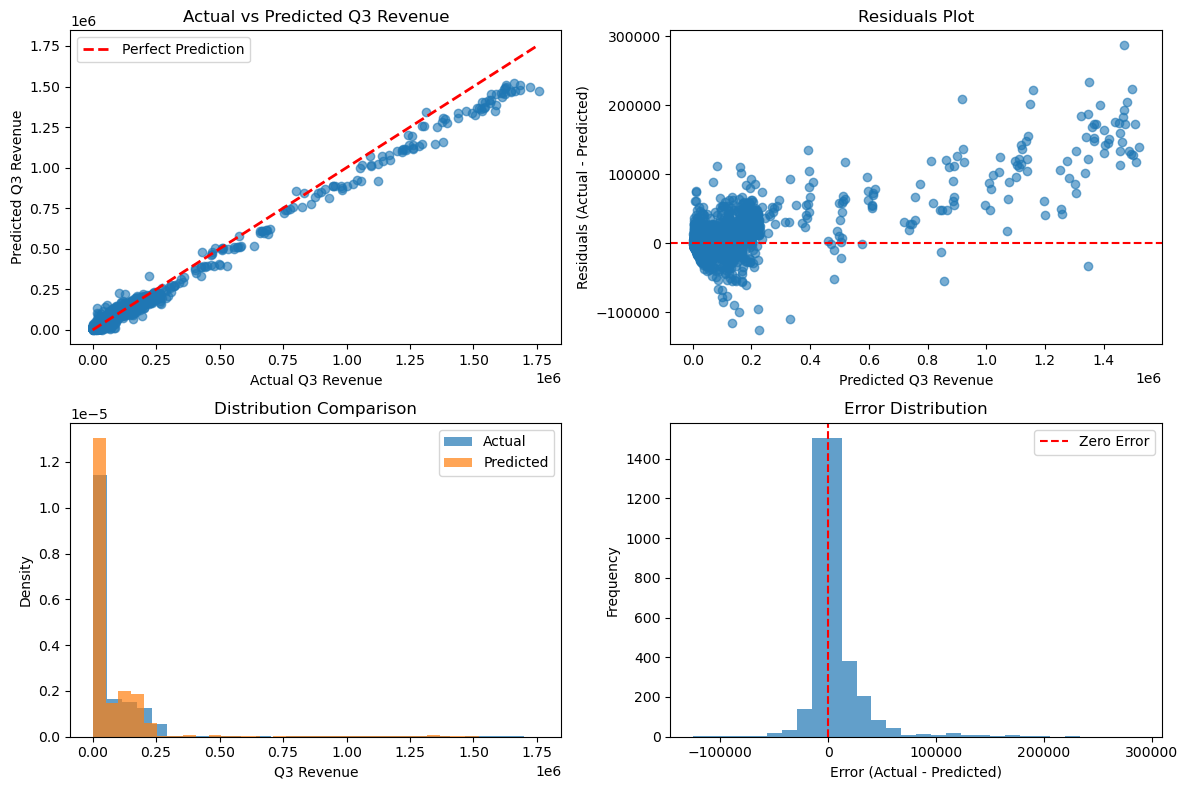

In [23]:
# Create a visualization of actual vs predicted
plt.figure(figsize=(12, 8))

# Scatter plot
plt.subplot(2, 2, 1)
plt.scatter(comparison_df['actual_q3_revenue'], comparison_df['predicted_q3_revenue'], alpha=0.6)
plt.plot([comparison_df['actual_q3_revenue'].min(), comparison_df['actual_q3_revenue'].max()], 
         [comparison_df['actual_q3_revenue'].min(), comparison_df['actual_q3_revenue'].max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Q3 Revenue')
plt.ylabel('Predicted Q3 Revenue')
plt.title('Actual vs Predicted Q3 Revenue')
plt.legend()

# Residuals plot
plt.subplot(2, 2, 2)
residuals = comparison_df['actual_q3_revenue'] - comparison_df['predicted_q3_revenue']
plt.scatter(comparison_df['predicted_q3_revenue'], residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Q3 Revenue')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Plot')

# Distribution of actual vs predicted
plt.subplot(2, 2, 3)
plt.hist(comparison_df['actual_q3_revenue'], bins=30, alpha=0.7, label='Actual', density=True)
plt.hist(comparison_df['predicted_q3_revenue'], bins=30, alpha=0.7, label='Predicted', density=True)
plt.xlabel('Q3 Revenue')
plt.ylabel('Density')
plt.title('Distribution Comparison')
plt.legend()

# Error distribution
plt.subplot(2, 2, 4)
plt.hist(residuals, bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()

plt.tight_layout()
# Correlation between actual and predicted
correlation = comparison_df['actual_q3_revenue'].corr(comparison_df['predicted_q3_revenue'])
print(f"\nCorrelation between actual and predicted: {correlation:.4f}")

## Predicting Future Revenue

In [ ]:
data = pd.read_csv("../data/curated/revenue_forecast_dataset.csv")

# Convert to categorical (same as in training)
data['type'] = data['type'].astype('category')
data['month'] = data['month'].astype('category')
data['merchant_abn'] = data['merchant_abn'].astype('category')

scaler = joblib.load('../data/curated/revenue_forecast_scaler.pkl')

In [25]:
# Load the best hyperparameters from the saved JSON file
with open('artifacts/xgb_best_params.json', 'r') as f:
    saved_params = json.load(f)
    best_params = saved_params['params']

print("Loaded hyperparameters:")
print(json.dumps(best_params, indent=2))

Loaded hyperparameters:
{
  "max_depth": 4,
  "min_child_weight": 2,
  "gamma": 0.3312207106640035,
  "reg_lambda": 13.026102601575124,
  "reg_alpha": 0.012211764741229649,
  "subsample": 0.9922405872712441,
  "colsample_bytree": 0.7275791676121519,
  "learning_rate": 0.03402810811212028,
  "max_bin": 256,
  "objective": "reg:squarederror",
  "eval_metric": "mae",
  "device": "cuda",
  "tree_method": "hist",
  "random_state": 42,
  "n_estimators": 311
}


In [26]:
# Create training split (March 2021 to August 2022)
train_full = data[(data['year_month'] >= '2021-03') & (data['year_month'] <= '2022-08')]
x_train_full = train_full.drop(columns=['monthly_revenue_future1', 'year_month'])  # keep merchant_abn now
y_train_full = train_full['monthly_revenue_future1']

# Scale only numerical features (same as in hyperparameter tuning)
available_categorical_cols = ['type', 'month', 'merchant_abn']  # include merchant_abn as categorical
numerical_cols = [col for col in x_train_full.columns if col not in available_categorical_cols]

# Scale numerical features
x_train_full_numerical_scaled = scaler.transform(x_train_full[numerical_cols])
x_train_full_scaled = pd.DataFrame(x_train_full_numerical_scaled, columns=numerical_cols, index=x_train_full.index)
x_train_full_scaled = pd.concat([x_train_full_scaled, x_train_full[available_categorical_cols]], axis=1)

print(f"Training data shape: {x_train_full_scaled.shape}")
print(f"Training target shape: {y_train_full.shape}")
print(f"Training period: {train_full['year_month'].min()} to {train_full['year_month'].max()}")
print(f"Categorical columns: {available_categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Training data shape: (72468, 15)
Training target shape: (72468,)
Training period: 2021-03 to 2022-08
Categorical columns: ['type', 'month', 'merchant_abn']
Numerical columns: ['relative_time', 'monthly_revenue', 'abs_retail', 'abs_retail_lag1', 'abs_retail_lag2', 'cpi', 'cpi_lag1', 'cpi_lag2', 'rba_cash_rate', 'rba_cash_rate_lag1', 'rba_cash_rate_lag2', 'take_rate']


In [27]:
# Train the XGBoost model with the best hyperparameters
# Create a copy of parameters for final training
train_params = best_params.copy()
train_params.pop('early_stopping_rounds', None)  # Remove early stopping parameter

# Use the saved best_n_estimators if available, otherwise use a reasonable default
best_n_estimators = saved_params.get('best_n_estimators', 1000)
train_params['n_estimators'] = best_n_estimators

print(f"Using n_estimators: {best_n_estimators}")

# Initialize model with training parameters
model = XGBRegressor(**train_params, enable_categorical=True, max_cat_to_onehot=1)

# Train the model
model.fit(x_train_full_scaled, y_train_full, verbose=False)

print("Model training completed!")
print(f"Number of estimators used: {model.n_estimators}")
print(f"Training data feature count: {x_train_full.shape[1]}")

Using n_estimators: 311


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [19:12:59] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Model training completed!
Number of estimators used: 311
Training data feature count: 15


In [28]:
# Implement recursive forecasting for future revenue prediction (Q4 2022)
# Using September 2022 as starting point to predict October, November, December 2022

# Get data for September (starting point) and the months we want to forecast: October, November, December 2022
future_forecast_months = ['2022-09', '2022-10', '2022-11', '2022-12']
future_forecast_df = data[data['year_month'].isin(future_forecast_months)].copy()

print(f"Future forecast dataframe shape: {future_forecast_df.shape}")
print(f"Months in future dataset: {sorted(future_forecast_df['year_month'].unique())}")
print(f"Companies in future dataset: {future_forecast_df['merchant_abn'].nunique()}")

# For October, November, and December, set the revenue columns to null (they will be predicted)
# September will keep its actual revenue as the starting point
future_months_to_null = ['2022-10', '2022-11', '2022-12']
for month in future_months_to_null:
    month_mask = future_forecast_df['year_month'] == month
    future_forecast_df.loc[month_mask, 'monthly_revenue'] = np.nan
    future_forecast_df.loc[month_mask, 'monthly_revenue_future1'] = np.nan

# Add a column for predicted revenue
future_forecast_df['predicted_revenue'] = np.nan

print(f"\nFuture forecast setup complete. September has actual revenue, Oct/Nov/Dec have null revenue (to be predicted)")

# Check revenue status by month
revenue_status = future_forecast_df.groupby('year_month')['monthly_revenue'].agg(['count', lambda x: x.isna().sum()])
revenue_status.columns = ['total_entries', 'null_revenues']
print(f"\nRevenue status by month:")
print(revenue_status)

Future forecast dataframe shape: (16104, 17)
Months in future dataset: ['2022-09', '2022-10', '2022-11', '2022-12']
Companies in future dataset: 4026

Future forecast setup complete. September has actual revenue, Oct/Nov/Dec have null revenue (to be predicted)

Revenue status by month:
            total_entries  null_revenues
year_month                              
2022-09              4026              0
2022-10                 0           4026
2022-11                 0           4026
2022-12                 0           4026


In [29]:
# Recursive forecasting function
def recursive_forecast(df, model, scaler, months_to_predict):
    """
    Perform recursive forecasting for multiple months
    
    df: dataframe with the structure for all months
    model: trained XGBoost model
    scaler: fitted scaler
    months_to_predict: list of months to predict in order (e.g., ['2022-07', '2022-08', '2022-09'])
    """
    
    forecast_df = df.copy()
    
    # Get all available months and sort them to determine previous month dynamically
    all_months = sorted(forecast_df['year_month'].unique())
    
    for month in months_to_predict:
        print(f"Predicting for {month}...")
        
        # Get data for current month
        current_month_mask = forecast_df['year_month'] == month
        current_month_data = forecast_df[current_month_mask].copy()
        
        # Find the previous month dynamically
        current_month_idx = all_months.index(month)
        if current_month_idx > 0:
            prev_month = all_months[current_month_idx - 1]
        else:
            raise ValueError(f"No previous month found for {month}")
        
        # For each company, use the previous month's revenue (actual or predicted)
        for idx in current_month_data.index:
            merchant_abn = current_month_data.loc[idx, 'merchant_abn']
            
            prev_mask = (forecast_df['merchant_abn'] == merchant_abn) & (forecast_df['year_month'] == prev_month)
            
            # Check if previous month has actual revenue or predicted revenue
            prev_actual_revenue = forecast_df.loc[prev_mask, 'monthly_revenue']
            prev_predicted_revenue = forecast_df.loc[prev_mask, 'predicted_revenue']
            
            if not prev_actual_revenue.isna().iloc[0]:
                # Use actual revenue from previous month
                prev_revenue = prev_actual_revenue.iloc[0]
            else:
                # Use predicted revenue from previous month
                prev_revenue = prev_predicted_revenue.iloc[0]
            
            # Update the monthly_revenue for current prediction
            current_month_data.loc[idx, 'monthly_revenue'] = prev_revenue
        
        # Prepare features for prediction (drop target and identifier columns only)
        # Keep merchant_abn as it's now a feature
        feature_cols = [col for col in current_month_data.columns 
                       if col not in ['monthly_revenue_future1', 'year_month', 'predicted_revenue']]
        
        X_current = current_month_data[feature_cols]
        
        # Handle categorical and numerical features separately for scaling
        available_categorical_cols = ['type', 'month', 'merchant_abn']  # include merchant_abn as categorical
        numerical_cols = [col for col in X_current.columns if col not in available_categorical_cols]
        
        # Scale only numerical features
        X_current_numerical_scaled = scaler.transform(X_current[numerical_cols])
        X_current_scaled = pd.DataFrame(X_current_numerical_scaled, columns=numerical_cols, index=X_current.index)
        X_current_scaled = pd.concat([X_current_scaled, X_current[available_categorical_cols]], axis=1)
        
        # Make predictions
        predictions = model.predict(X_current_scaled)
        
        # Store predictions in the forecast dataframe
        forecast_df.loc[current_month_mask, 'predicted_revenue'] = predictions
        
        # Also update monthly_revenue_future1 which represents the revenue for next month
        # This will be used for evaluation
        forecast_df.loc[current_month_mask, 'monthly_revenue_future1'] = predictions
        
        print(f"Completed predictions for {month}. Mean prediction: {predictions.mean():.2f}")
    
    return forecast_df

In [30]:
# Perform recursive forecasting for future months (October, November, December 2022)
# Note: September 2022 uses actual revenue, we predict October, November, and December recursively

future_months_to_predict = ['2022-10', '2022-11', '2022-12']
future_final_forecast = recursive_forecast(future_forecast_df, model, scaler, future_months_to_predict)

print("Future recursive forecasting completed!")
print(f"Future forecast dataframe shape: {future_final_forecast.shape}")

# Check for any missing predictions
missing_future_predictions = future_final_forecast['predicted_revenue'].isna().sum()
print(f"Missing future predictions: {missing_future_predictions}")

# Summary statistics of predictions by month
future_prediction_stats = future_final_forecast.groupby('year_month')['predicted_revenue'].agg(['count', 'mean', 'std'])
print(f"\nFuture prediction statistics by month:")
print(future_prediction_stats)

Predicting for 2022-10...
Completed predictions for 2022-10. Mean prediction: 37391.87
Predicting for 2022-11...
Completed predictions for 2022-11. Mean prediction: 33598.60
Predicting for 2022-12...
Completed predictions for 2022-12. Mean prediction: 22958.36
Future recursive forecasting completed!
Future forecast dataframe shape: (16104, 18)
Missing future predictions: 4026

Future prediction statistics by month:
            count          mean           std
year_month                                   
2022-09         0           NaN           NaN
2022-10      4026  37391.868658  83253.198182
2022-11      4026  33598.600423  73911.370758
2022-12      4026  22958.356504  50705.620704


In [31]:
# Aggregate predicted revenues by company for Q4 2022 (October, November, December)
predicted_q4_data = future_final_forecast[future_final_forecast['year_month'].isin(['2022-10', '2022-11', '2022-12'])].copy()
predicted_q4_revenue = predicted_q4_data.groupby('merchant_abn')['predicted_revenue'].sum().reset_index()
predicted_q4_revenue.columns = ['merchant_abn', 'predicted_q4_revenue']

print(f"Companies with predicted Q4 data: {len(predicted_q4_revenue)}")
print(f"Mean predicted Q4 revenue: ${predicted_q4_revenue['predicted_q4_revenue'].mean():.2f}")
print(f"Median predicted Q4 revenue: ${predicted_q4_revenue['predicted_q4_revenue'].median():.2f}")
print(f"Std predicted Q4 revenue: ${predicted_q4_revenue['predicted_q4_revenue'].std():.2f}")

print(f"\nSample Q4 revenue predictions (first 10 companies):")
print(predicted_q4_revenue.head(10))

# Summary statistics
print(f"\nQ4 2022 Revenue Forecast Summary:")
print(f"Total companies: {len(predicted_q4_revenue)}")
print(f"Total predicted Q4 revenue: ${predicted_q4_revenue['predicted_q4_revenue'].sum():.2f}")
print(f"Average revenue per company: ${predicted_q4_revenue['predicted_q4_revenue'].mean():.2f}")

# Show distribution of predictions
print(f"\nQ4 Revenue Distribution:")
print(f"Min: ${predicted_q4_revenue['predicted_q4_revenue'].min():.2f}")
print(f"25th percentile: ${predicted_q4_revenue['predicted_q4_revenue'].quantile(0.25):.2f}")
print(f"50th percentile: ${predicted_q4_revenue['predicted_q4_revenue'].quantile(0.5):.2f}")
print(f"75th percentile: ${predicted_q4_revenue['predicted_q4_revenue'].quantile(0.75):.2f}")
print(f"Max: ${predicted_q4_revenue['predicted_q4_revenue'].max():.2f}")

Companies with predicted Q4 data: 4026
Mean predicted Q4 revenue: $93948.83
Median predicted Q4 revenue: $27591.05
Std predicted Q4 revenue: $207788.69

Sample Q4 revenue predictions (first 10 companies):
  merchant_abn  predicted_q4_revenue
0  10023283211         145067.734375
1  10142254217          24538.424805
2  10165489824          16613.703369
3  10187291046           8188.844727
4  10192359162          33783.423828
5  10206519221          74336.828125
6  10255988167          67673.808594
7  10264435225         111080.638672
8  10279061213          30248.431152
9  10323485998         214381.679688

Q4 2022 Revenue Forecast Summary:
Total companies: 4026
Total predicted Q4 revenue: $378237971.80
Average revenue per company: $93948.83

Q4 Revenue Distribution:
Min: $-1357.64
25th percentile: $9019.21
50th percentile: $27591.05
75th percentile: $110892.76
Max: $1652442.59


/var/folders/mt/_r39z94x2mv2hjn950c58jp40000gn/T/ipykernel_16268/159964322.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_q4_revenue = predicted_q4_data.groupby('merchant_abn')['predicted_revenue'].sum().reset_index()


In [32]:
detailed_q4_predictions = future_final_forecast[['merchant_abn', 'year_month', 'predicted_revenue']].copy()
detailed_q4_predictions = detailed_q4_predictions[detailed_q4_predictions['year_month'].isin(['2022-10', '2022-11', '2022-12'])]

In [33]:
detailed_q4_predictions.head(10)

,merchant_abn,year_month,predicted_revenue
19,10023283211,2022-10,57981.085938
20,10023283211,2022-11,52174.601562
21,10023283211,2022-12,34912.046875
41,10142254217,2022-10,8701.117188
42,10142254217,2022-11,9101.930664
43,10142254217,2022-12,6735.376953
63,10165489824,2022-10,6347.573242
64,10165489824,2022-11,6298.442383
65,10165489824,2022-12,3967.687744
85,10187291046,2022-10,3116.471924


In [34]:
# Clip negative forecasts to 0 and aggregate by company for next quarter revenue

# Create a copy of detailed Q4 predictions to avoid modifying the original
clipped_q4_predictions = detailed_q4_predictions.copy()

# Clip negative predicted revenues to 0
clipped_q4_predictions['predicted_revenue'] = np.maximum(clipped_q4_predictions['predicted_revenue'], 0)

# Aggregate by company to get total next quarter revenue
next_quarter_revenue = clipped_q4_predictions.groupby('merchant_abn')['predicted_revenue'].sum().reset_index()
next_quarter_revenue.columns = ['merchant_abn', 'next_quarter_revenue']

/var/folders/mt/_r39z94x2mv2hjn950c58jp40000gn/T/ipykernel_16268/141073120.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  next_quarter_revenue = clipped_q4_predictions.groupby('merchant_abn')['predicted_revenue'].sum().reset_index()


In [ ]:
# Save the next quarter revenue forecast data as CSV file
next_quarter_revenue.to_csv('../data/curated/next_quarter_revenue_forecast.csv', index=False)
print("Next quarter revenue forecast saved to next_quarter_revenue_forecast.csv")

Next quarter revenue forecast saved to 'data/curated/next_quarter_revenue_forecast.csv'
